In [1]:
%load_ext cython

In [2]:
pos = np.loadtxt('../../../multiscale/test_input/3d_6_0.54_0.dat', usecols=range(3))

In [ ]:
### Output a list of list

In [108]:
%%cython -a
from libc.math cimport floor, sqrt

def generate_kvec3D(int nk, int maxNvec=30):
    kvectors = []
    cdef int i,j,k
    for i in range(nk):
        if len(kvectors) >= maxNvec: break
        for j in range(int(sqrt(nk*nk-i*i))):
            if len(kvectors) >= maxNvec: break
            k = int(sqrt(nk*nk-i*i-j*j))
            #if k != int(k): continue
            kvectors.append([i,j,k])
            kvectors.append([j,k,i])
            kvectors.append([k,i,j])
    return kvectors

Pure python code

In [14]:
%timeit generate_kvec3D(60)

1000 loops, best of 3: 489 µs per loop


typing arguments

In [16]:
%timeit generate_kvec3D(60)

1000 loops, best of 3: 387 µs per loop


typing `i`

In [18]:
%timeit generate_kvec3D(60)

1000 loops, best of 3: 345 µs per loop


Typing `j`

In [20]:
%timeit generate_kvec3D(60)

1000 loops, best of 3: 202 µs per loop


converting the sqrt into int

In [27]:
%timeit generate_kvec3D(60)

100000 loops, best of 3: 3.61 µs per loop


Typing `k`

In [29]:
%timeit generate_kvec3D(60)

100000 loops, best of 3: 3.34 µs per loop


Giving up the test on `k`

In [3]:
%timeit generate_kvec3D(60)

100000 loops, best of 3: 2.63 µs per loop


In [57]:
%timeit generate_kvec3D(60, 300)

10000 loops, best of 3: 26.4 µs per loop


In [5]:
%timeit generate_kvec3D(60)

The slowest run took 4.09 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.5 µs per loop


### Output a numpy array

Quite verbose implementation, very "C", but much quicker than the list, since there is no memory allocation. Also, listing the different allocations is much quicker than rolling along an axis or using the i,j,k syntax on the right hand side.

In [6]:
%%cython -a
import numpy as np
cimport numpy as np
from libc.math cimport floor, sqrt

DTYPE = np.int
ctypedef np.int_t DTYPE_t

def generate_kvec3D(int nk, np.ndarray[DTYPE_t, ndim=2] kvectors):
    cdef int maxNvec = len(kvectors)
    assert maxNvec%3 == 0
    cdef int i,j,k
    cdef int nvec = 0
    for i in range(nk):
        if nvec >= maxNvec: break
        #for j in range(int(sqrt(nk*nk-i*i))):
        j=0
        while j**2 < nk**2 - i**2:
            if nvec >= maxNvec: break
            k = int(sqrt(nk*nk-i*i-j*j))
            #if k != int(k): continue
            kvectors[nvec,0] = i
            kvectors[nvec,1] = j
            kvectors[nvec,2] = k
            kvectors[nvec+1,0] = j
            kvectors[nvec+1,1] = k
            kvectors[nvec+1,2] = i
            kvectors[nvec+2,0] = k
            kvectors[nvec+2,1] = i
            kvectors[nvec+2,2] = j
            nvec += 3
            j += 1
    return kvectors[:nvec]

preallocating memory

In [7]:
kvectors = np.zeros([300,3], int)

In [8]:
%timeit generate_kvec3D(60, kvectors)

100000 loops, best of 3: 1.94 µs per loop


In [8]:
%timeit generate_kvec3D(60, kvectors)

The slowest run took 13.07 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.05 µs per loop


### In 2D, sample the trigonometric circle

Nympy implementation

In [9]:
def generate_kvec2D(nk, kvectors):
    maxNvec = len(kvectors)
    x = np.unique((nk*np.sin(np.linspace(0, 0.25*np.pi, maxNvec/2))).astype(int))
    y = np.sqrt(nk**2 - x**2).astype(int)
    nvec = 2*len(x)
    kvectors[:nvec:2, 0] = x
    kvectors[:nvec:2, 1] = y
    kvectors[1:nvec:2, 0] = y
    kvectors[1:nvec:2, 1] = x
    return kvectors[:nvec]

In [10]:
%timeit generate_kvec2D(60, kvectors)

The slowest run took 7.18 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 50.1 µs per loop


Cython implementation

In [28]:
%%cython -a
import numpy as np
cimport numpy as np
from libc.math cimport floor, sqrt, sin, M_PI

#DTYPE = np.int
ctypedef np.int_t DTYPE_t

def generate_kvec2D(int nk, np.ndarray[DTYPE_t, ndim=2] kvectors):
    cdef int maxNvec = kvectors.shape[0]
    cdef double M = 0.5*M_PI/maxNvec
    cdef int i,j,u
    cdef int nvec = 0
    
    for u in range(maxNvec/2):
        i = int(nk * sin(M * u))
        if nvec >0 and kvectors[nvec-1, 0] == i:
            continue
        j = int(sqrt(nk**2 - i**2))
        kvectors[nvec,0] = i
        kvectors[nvec,1] = j
        kvectors[nvec+1,0] = j
        kvectors[nvec+1,1] = i
        nvec += 2

    return kvectors[:nvec]

In [12]:
%timeit generate_kvec2D(60, kvectors)

The slowest run took 5.52 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 5.38 µs per loop


In [29]:
%timeit generate_kvec2D(60, kvectors)

The slowest run took 4.39 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.81 µs per loop


## Sq

Pure Python implementation

In [98]:
def get_Sq(pos, Nbins, L=203.0, maxNvec=30, field=None):
    if field is None:
        field = np.ones(len(pos))
    assert len(field) == len(pos)
    Sq = np.zeros(Nbins)
    #cache the complex exponential caculations
    cache = np.ones(list(pos.shape)+[Nbins], np.complex128)
    for i, po in enumerate(pos):
        for j, p in enumerate(po):
            e = np.exp(2j*np.pi/L * p)
            for nk in range(1,len(Sq)):
                cache[i,j, nk] = cache[i,j,nk-1] * e
    kVectors = np.zeros((maxNvec, pos.shape[-1]), dtype=int)
    for nk in range(1,len(Sq)):
        #generate the k-vectors
        if pos.shape[-1] == 2:
            kvectors = generate_kvec2D(nk, kVectors)
        elif pos.shape[-1] == 3:
            kvectors = generate_kvec3D(nk, kVectors)
        else:
            raise NotImplementedError("generation of k-vectors in {} dimensions is not implemented".format(pos.shape[-1]))
        for kvs in kvectors:
            sum_rho = 0j
            for i, f in enumerate(field):
                prod = complex(f)
                for j, kv in enumerate(kvs):
                    #random access to cache
                    prod *= cache[i, j, kv]
                sum_rho += prod
            Sq[nk] += sum_rho.real**2 + sum_rho.imag**2
        Sq[nk] /= len(kvectors)
    return Sq/len(pos)

In [90]:
pos.ptp(0)

array([ 202.9822357 ,  202.981967  ,  202.97583994])

In [103]:
Sq = get_Sq(pos[:100], 60, L=203)

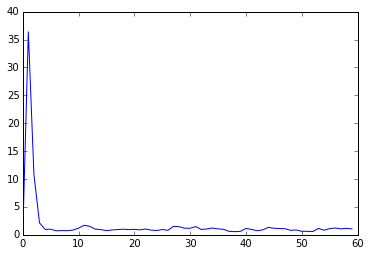

In [104]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(Sq)

In [105]:
np.save('Sq100.npy', Sq)

In [101]:
np.all(np.load('Sq.npy') == Sq)

True

In [106]:
%timeit get_Sq(pos[:100], 60, L=203)

1 loops, best of 3: 632 ms per loop


Cython

In [91]:
%%cython -a 
cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport floor, sqrt, sin, M_PI
cdef extern from "complex.h":
    double complex cexp(double complex)
    double creal(double complex);
    double cimag(double complex);

ctypedef np.int_t DTYPE_t

@cython.boundscheck(False)
cdef DTYPE_t generate_kvec3D(int nk, np.ndarray[DTYPE_t, ndim=2] kvectors):
    cdef DTYPE_t maxNvec = kvectors.shape[0]
    assert maxNvec%3 == 0
    cdef int i,j,k
    cdef DTYPE_t nvec = 0
    for i in range(nk):
        if nvec >= maxNvec: break
        #for j in range(int(sqrt(nk*nk-i*i))):
        j=0
        while j**2 < nk**2 - i**2:
            if nvec >= maxNvec: break
            k = int(sqrt(nk*nk-i*i-j*j))
            #if k != int(k): continue
            kvectors[nvec,0] = i
            kvectors[nvec,1] = j
            kvectors[nvec,2] = k
            kvectors[nvec+1,0] = j
            kvectors[nvec+1,1] = k
            kvectors[nvec+1,2] = i
            kvectors[nvec+2,0] = k
            kvectors[nvec+2,1] = i
            kvectors[nvec+2,2] = j
            nvec += 3
            j += 1
    return nvec

@cython.boundscheck(False)
cdef DTYPE_t generate_kvec2D(int nk, np.ndarray[DTYPE_t, ndim=2] kvectors):
    cdef DTYPE_t maxNvec = kvectors.shape[0]
    cdef double M = 0.5*M_PI/maxNvec
    cdef int i,j,u
    cdef DTYPE_t nvec = 0
    
    for u in range(maxNvec/2):
        i = int(nk * sin(M * u))
        if nvec >0 and kvectors[nvec-1, 0] == i:
            continue
        j = int(sqrt(nk**2 - i**2))
        kvectors[nvec,0] = i
        kvectors[nvec,1] = j
        kvectors[nvec+1,0] = j
        kvectors[nvec+1,1] = i
        nvec += 2

    return nvec

def get_Sq(np.ndarray[np.float64_t, ndim=2] pos, int Nbins, double L=203.0, DTYPE_t maxNvec=30, np.ndarray[double complex, ndim=1]field=None):
    if pos.shape[1] ==2:
        generate_kvec = generate_kvec2D
    elif pos.shape[1] == 3:
        generate_kvec = generate_kvec3D
    else:
        raise NotImplementedError("generation of k-vectors in {} dimensions is not implemented".format(pos.shape[1]))
    if field is None:
        field = np.ones(pos.shape[0], np.complex128)
    assert field.shape[0] == pos.shape[0]
    cdef double complex prod, sum_rho, e
    cdef DTYPE_t i, j, k, nk, kv, nvec
    cdef double p
    cdef np.ndarray[DTYPE_t, ndim=2] kvectors= np.zeros((maxNvec, pos.shape[1]), dtype=int)
    cdef np.ndarray[double, ndim=1] Sq = np.zeros(Nbins)
    #cache the complex exponential caculations
    cdef np.ndarray[double complex, ndim=3] cache = np.ones([Nbins, pos.shape[0], pos.shape[1]], np.complex128)
    for i in range(pos.shape[0]):
        for j in range(pos.shape[1]):
            p = pos[i,j]
            e = cexp(2j*M_PI/L * p)
            for nk in range(1,Sq.shape[0]):
                cache[nk, i, j] = cache[nk-1, i, j] * e
    for nk in range(1,Sq.shape[0]):
        #generate the k-vectors
        nvec = generate_kvec(nk, kvectors)
        for k in range(nvec):
            sum_rho = 0j
            for i in range(pos.shape[0]):
                prod = field[i]
                for j in range(pos.shape[1]):
                    kv = kvectors[k,j]
                    #random access to cache
                    prod *= cache[kv, i, j]
                sum_rho += prod
            Sq[nk] += creal(sum_rho)**2 + cimag(sum_rho)**2
        Sq[nk] /= nvec
    return Sq / pos.shape[0]

In [107]:
%timeit get_Sq(pos[:100], 60, L=203)

100 loops, best of 3: 3.48 ms per loop


In [93]:
%timeit get_Sq(pos, 60, L=203)

1 loops, best of 3: 666 ms per loop


In [94]:
Sq600 = get_Sq(pos, 60, L=203, maxNvec=600)

## Retangular Sq

In [42]:
%%cython -a 
cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport floor, ceil, sqrt, sin, M_PI
cdef extern from "complex.h":
    double complex cexp(double complex)
    double creal(double complex);
    double cimag(double complex);

ctypedef np.int_t DTYPE_t

@cython.boundscheck(False)
cdef DTYPE_t generate_kvec3D_rect(int nk, np.ndarray[DTYPE_t, ndim=2] kvectors, np.ndarray[double, ndim=1] Lsq):
    cdef DTYPE_t maxNvec = kvectors.shape[0]
    cdef int i,j,k, jmax, kmin, kmax
    cdef double ksqmax, ksqmin
    cdef DTYPE_t nvec = 0
    for i in range(nk+1):
        if nvec >= maxNvec: break
        #for j in range(int(sqrt(nk*nk-i*i))):
        jmax = int(ceil(sqrt(Lsq[1] * (nk**2) / Lsq[0])))
        print('i {} jmax {}'.format(i, jmax))
        for j in range(jmax):
            if nvec >= maxNvec: break
            ksqmax = Lsq[2] * ((nk**2 - i**2)/Lsq[0] - j**2/Lsq[1])
            ksqmin = Lsq[2] * (((nk-1)**2 - i**2)/Lsq[0] - j**2/Lsq[1])
            print('j {} ksqmax {} ksqmin {}'.format(j, ksqmax, ksqmin))
            if ksqmin<0: ksqmin = 0
            kmin = int(floor(sqrt(ksqmin)))+1
            kmax = int(floor(sqrt(ksqmax)))+1
            print("kmin {} kmax {}".format(kmin, kmax))
            for k in range(kmin, kmax):
                if nvec >= maxNvec: break
                print("k {}".format(k))
                kvectors[nvec,0] = i
                kvectors[nvec,1] = j
                kvectors[nvec,2] = k
                nvec += 1
    return nvec

kkk = np.zeros((60, 3), dtype=int)
nn = generate_kvec3D_rect(1, kkk, np.array([203.0]*3))
print(nn)
print(kkk[:nn])

@cython.boundscheck(False)
cdef DTYPE_t generate_kvec2D_rect(int nk, np.ndarray[DTYPE_t, ndim=2] kvectors, np.ndarray[double, ndim=1] Lsq):
    cdef DTYPE_t maxNvec = kvectors.shape[0]
    assert maxNvec%2 == 0
    cdef int i,j, jmin, jmax
    cdef double jsqmax, jsqmin
    cdef DTYPE_t nvec = 0
    for i in range(nk+1):
        if nvec >= maxNvec: break
        jsqmax = Lsq[1] * (nk**2 - i**2)/Lsq[0]
        jsqmin = Lsq[1] * ((nk-1)**2 - i**2)/Lsq[0]
        if jsqmin<0: jsqmin = 0
        jmin = int(sqrt(jsqmin))
        jmax = int(sqrt(jsqmax))
        for j in range(jmin, jmax):
            if nvec >= maxNvec: break
            kvectors[nvec,0] = i
            kvectors[nvec,1] = j
            nvec += 1
    return nvec

def rectangular_Sq(
        np.ndarray[np.float64_t, ndim=2] positions, 
        int Nbins, np.ndarray[double, ndim=1] Ls=np.array([203.0]*3), DTYPE_t maxNvec=30, 
        np.ndarray[double complex, ndim=1] field=None
    ):
    if positions.shape[1] == 2:
        generate_kvec = generate_kvec2D_rect
    elif positions.shape[1] == 3:
        generate_kvec = generate_kvec3D_rect
    else:
        raise NotImplementedError("generation of k-vectors in {} dimensions is not implemented".format(positions.shape[1]))
    if field is None:
        field = np.ones(positions.shape[0], np.complex128)
    assert field.shape[0] == positions.shape[0]
    cdef double complex prod, sum_rho, e
    cdef DTYPE_t i, j, k, nk, kv, nvec
    cdef double p, L
    cdef np.ndarray[DTYPE_t, ndim=2] kvectors = np.zeros((maxNvec, positions.shape[1]), dtype=int)
    cdef np.ndarray[double, ndim=1] Sq = np.zeros(Nbins)
    #sort xyz by decreasing box size
    cdef np.ndarray[double, ndim=2] pos = positions[:, np.argsort(Ls)[::-1]]
    cdef np.ndarray[double, ndim=1] dims = np.sort(Ls)[::-1]
    cdef np.ndarray[double, ndim=1] Lsq = dims.astype(float)**2
    #cache the complex exponential caculations
    cdef np.ndarray[double complex, ndim=3] cache = np.ones([Nbins, pos.shape[0], pos.shape[1]], np.complex128)
    for i in range(pos.shape[0]):
        for j in range(pos.shape[1]):
            p = pos[i,j]
            L = dims[j]
            e = cexp(2j*M_PI/L * p)
            for nk in range(1,Sq.shape[0]):
                cache[nk, i, j] = cache[nk-1, i, j] * e
    for nk in range(1,Sq.shape[0]):
        #generate the k-vectors
        nvec = generate_kvec(nk, kvectors, Lsq)
        for k in range(nvec):
            sum_rho = 0j
            for i in range(pos.shape[0]):
                prod = field[i]
                for j in range(pos.shape[1]):
                    kv = kvectors[k,j]
                    #random access to cache
                    prod *= cache[kv, i, j]
                sum_rho += prod
            Sq[nk] += creal(sum_rho)**2 + cimag(sum_rho)**2
        Sq[nk] /= nvec
    return Sq / pos.shape[0]

i 0 jmax 1
j 0 ksqmax 1.0 ksqmin 0.0
kmin 1 kmax 2
k 1
i 1 jmax 1
j 0 ksqmax 0.0 ksqmin -1.0
kmin 1 kmax 1
1
[[0 0 1]]


In [6]:
%timeit rectangular_Sq(pos[:100], 60)

100 loops, best of 3: 3.62 ms per loop


In [8]:
Sq = rectangular_Sq(pos, 60)

In [9]:
np.all(np.load('Sq.npy') == Sq)

False

In [12]:
np.mean((np.load('Sq.npy') - Sq)**2)

nan

In [18]:
np.where(np.isnan(Sq))

(array([1]),)

In [109]:
def rectangular_Sq(pos, Nbins, Ls=[203.0]*3, field=None):
    if field is None:
        field =np.ones(pos.shape[0])
    Lmax = max(Ls)
    ns = [np.arange(int(Nbins * Lmax/L) +1) for L in Ls]
    distsq = np.zeros([n.shape[0] for n in ns])
    for axis, n in enumerate(ns):
        distsq += (Lmax/Ls[axis] * n.reshape([n.shape[0]] + [1]*(len(ns)-axis-1)))**2
    dist = np.sqrt(distsq)
    #generate the spectrum
    sum_rho = np.zeros(distsq.shape, np.complex128)
    for po,f in zip(pos, field):
        prod = np.full(distsq.shape, f, np.complex128)
        for axis, (p, L, n) in enumerate(zip(po, Ls, ns)):
            e = np.exp(2j*np.pi/L * p)
            prod *= e**n.reshape([n.shape[0]] + [1]*(len(ns)-axis-1))
        sum_rho += prod
    spectrum = sum_rho.real**2 + sum_rho.imag**2
    return np.histogram(dist, bins=np.arange(Nbins+1), weights=spectrum)[0]/np.histogram(dist, bins=np.arange(Nbins+1))[0]/pos.shape[0]

In [110]:
Sq60 = rectangular_Sq(pos, 60)

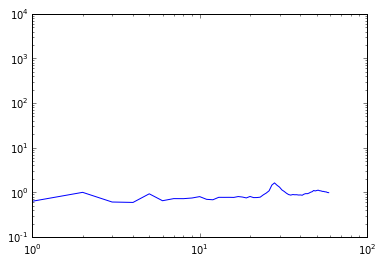

In [134]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(S)
plt.xscale('log')
plt.yscale('log')

In [136]:
%timeit rectangular_Sq(pos[::100], 60)

1 loops, best of 3: 692 ms per loop


In [59]:
def rectangular_Sq(pos, Nbins, Ls=[203.0]*3, field=None):
    if field is None:
        field =np.ones(pos.shape[0])
    Lmax = max(Ls)
    ns = [np.arange(int(Nbins * Lmax/L) +1) for L in Ls]
    #square distances from the center of the spectrum ($|q|^2$)
    distsq = np.zeros([n.shape[0] for n in ns])
    for axis, n in enumerate(ns):
        distsq += (Lmax/Ls[axis] * n.reshape([n.shape[0]] + [1]*(len(ns)-axis-1)))**2
    bins = ns[np.argmax(Ls)]**2
    #generate the spectrum
    sum_rho = np.zeros(distsq.shape, np.complex128)
    for po,f in zip(pos, field):
        prod = np.full(distsq.shape, f, np.complex128)
        for axis, (p, L, n) in enumerate(zip(po, Ls, ns)):
            e = np.exp(2j*np.pi/L * p)
            prod *= e**n.reshape([n.shape[0]] + [1]*(len(ns)-axis-1))
        sum_rho += prod
    spectrum = sum_rho.real**2 + sum_rho.imag**2
    #bin according to the distances
    return np.histogram(distsq, bins=bins, weights=spectrum)[0]/np.histogram(distsq, bins=bins)[0]/pos.shape[0]

In [60]:
%timeit rectangular_Sq(pos[::100], 60)

1 loops, best of 3: 653 ms per loop


In [41]:
def get_dists(Nbins, Ls=[203.0]*3):
    Lmax = max(Ls)
    ns = [np.arange(int(Nbins * Lmax/L) +1) for L in Ls]
    distsq = np.zeros([n.shape[0] for n in ns])
    for axis, n in enumerate(ns):
        distsq += (Lmax/Ls[axis] * n.reshape([n.shape[0]] + [1]*(len(ns)-axis-1)))**2
    return np.sqrt(distsq)

In [42]:
%timeit get_dists(60)

1000 loops, best of 3: 1.43 ms per loop


In [55]:
def get_dists(Nbins, Ls=np.full(3, 203.0)):
    Lmax = Ls.max()
    Nmaxs = (Nbins * Lmax/Ls).astype(int)
    distsq = np.zeros(Nmaxs)
    for axis, Nmax in enumerate(Nmaxs):
        distsq += (Lmax/Ls[axis] * np.arange(Nmax).reshape([Nmax] + [1]*(len(Ls)-axis-1)))**2
    return np.sqrt(distsq)

In [56]:
%timeit get_dists(60)

1000 loops, best of 3: 1.42 ms per loop


In [36]:
%%cython -a 
cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport floor, ceil, sqrt, sin, M_PI
cdef extern from "complex.h":
    double complex cexp(double complex)
    double creal(double complex);
    double cimag(double complex);

ctypedef np.int_t DTYPE_t

def get_dists(DTYPE_t ndim, DTYPE_t Nbins, np.ndarray[double, ndim=1] Ls=np.full(3, 203.0)):
    cdef double Lmax = max(Ls)
    Nmaxs = Nbins * Lmax/Ls
    dists = np.zeros(Nmaxs)
    for index in np.ndindex(*Nmaxs):
        dists[index] = sqrt(sum((Lmax/Ls * index)**2))
    return dists

In [37]:
%timeit get_dists(3, 60)

1 loops, best of 3: 3.79 s per loop


/home/mathieu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:257: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [19]:
%%cython -a 
cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport floor, ceil, sqrt, sin, M_PI
cdef extern from "complex.h":
    double complex cexp(double complex)
    double creal(double complex);
    double cimag(double complex);

ctypedef np.int_t DTYPE_t


def rectangular_Sq3D(
        np.ndarray[np.float64_t, ndim=2]pos, 
        int Nbins, 
        np.ndarray[np.float64_t, ndim=1]Ls=np.full(3,203.0), 
        np.ndarray[double complex, ndim=1]field=None
    ):
    if field is None:
        field = np.ones(pos.shape[0], np.complex128)
    cdef double Lmax = Ls.max()
    cdef int axis, p, i, j, k
    cdef double complex e, prev
    cdef np.ndarray[double complex, ndim=3] prod
    cdef np.ndarray[double complex, ndim=2] cache
    ns = [np.arange(int(Nbins * Lmax/L) +1) for L in Ls]
    distsq = np.zeros([n.shape[0] for n in ns])
    for axis, n in enumerate(ns):
        distsq += (Lmax/Ls[axis] * n.reshape([n.shape[0]] + [1]*(len(ns)-axis-1)))**2
    dist = np.sqrt(distsq)
    #generate the spectrum
    sum_rho = np.zeros(distsq.shape, np.complex128)
    for p in range(pos.shape[0]):
        cache = np.ones((Nbins+1, 3), np.complex128)
        for axis in range(pos.shape[1]):
            e = np.exp(2j*np.pi/Ls[axis] * pos[p,axis])
            cache[:ns[axis].shape[0]] = e**ns[axis]
        #compute product for each q-vector
        prod = np.full(distsq.shape, field[p], np.complex128)
        for i in range(prod.shape[0]):
            for j in range(prod.shape[1]):
                for k in range(prod.shape[2]):
                    prod[i,j,k] *= np.prod(cache[axis, [i,j,k]])
                    
        sum_rho += prod
    spectrum = sum_rho.real**2 + sum_rho.imag**2
    return np.histogram(dist, bins=np.arange(Nbins+1), weights=spectrum)[0]/np.histogram(dist, bins=np.arange(Nbins+1))[0]/pos.shape[0]

In [20]:
S = rectangular_Sq(pos[:10], 60)

In [89]:
len(pos)*4*np.pi*4**3/3/203.**3

0.5250496929534014

In [103]:
np.histogram?

In [61]:
from colloids.statistics import StructureFactor3D

In [116]:
N = 1024
Sf = StructureFactor3D([N]*3)
Sf((pos/203.*N).astype(int), periodic=True)
Sq = Sf.get_S()/len(pos)

MemoryError: 

(0.01, 10.0)

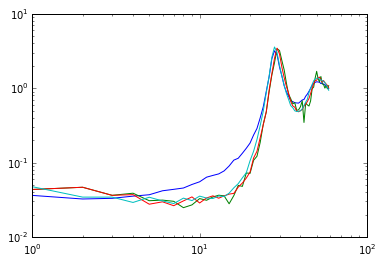

In [115]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(Sq)
plt.plot(np.load('Sq.npy'))
plt.plot(Sq600)
plt.plot(Sq60)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,1e1)

Starting on lattice `StructureFactor3D`, with a poor resolution, give a poor result. Ending on a lattice and then performing radial average is precise but slow. Selecting a subset of q-vectors is efficient, but the subset must be large enough (300-600), furthemore good, isotropic, implementation in the rectangulat case is still to be done.

In [67]:
Sq.shape

(59,)

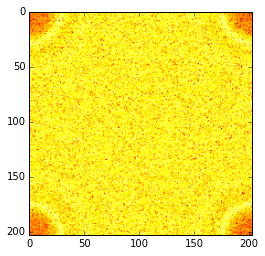

In [80]:
plt.imshow(np.log(Sf.spectrum[...,1]), 'hot')

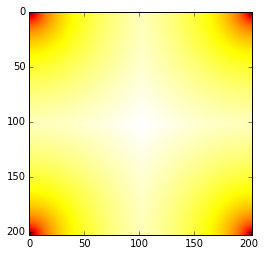

In [81]:
plt.imshow(np.log(Sf.dists[...,1]), 'hot')

In [ ]:
plt.plot()